## Some of the code cells are commented to either prevent them from rewriting  data to the Disk or to prevent the notebook from becoming long to read

In [25]:
import os
import tensorflow as tf
import numpy as np


import string
from tensorflow.keras.preprocessing.text import Tokenizer

import pandas as pd
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow.keras.utils as ku 
from keras import Input, layers
from keras.layers.merge import add
from keras.models import Model

from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop

In [26]:
os.getcwd()
myl = os.listdir('Flicker8k_Dataset/')
if "1000268201_693b08cb0e.jpg" in myl:
    print(1)

1


In [229]:
# myl

In [28]:
filename = "Flickr8k.token.txt"
file = open(filename, 'r')
doc = file.read()

In [29]:
doc.split('\n')[1].split('\t')

['1000268201_693b08cb0e.jpg#1', 'A girl going into a wooden building .']

In [30]:
my_dict = dict()
for line in doc.split('\n'):
    # split line by white space
    tokens = line.split(' ')
    
    # take the first token as image id, the rest as description
    image_id, image_desc = tokens[0], tokens[1:]
    
    # extract filename from image id
    image_id = image_id.split('.')[0] + '.jpg'
    if image_id in myl:    
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in my_dict:
            my_dict[image_id] = list()
            my_dict[image_id].append(image_desc)
        else:
            my_dict[image_id].append(image_desc)

In [31]:
# prepare translation table for removing punctuation
table = str.maketrans('', '', string.punctuation)
for key, desc_list in my_dict.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        # tokenize
        desc = desc.split()
        # convert to lower case
        desc = [word.lower() for word in desc]
#         print(desc)
        # remove punctuation from each token
        desc = [w.translate(table) for w in desc]
#         print(desc)
        # remove hanging 's' and 'a'
        desc = [word for word in desc if len(word)>1]
        # remove tokens with numbers in them
        desc = [word for word in desc if word.isalpha()]
        # store as string
#         print(desc,type(desc_list[i]))
        desc_list[i] =  ' '.join(desc)
    

In [32]:
type(my_dict)

dict

In [230]:
# my_dict

In [34]:
for i in my_dict.keys():
    for j in range(len(my_dict[i])):
        my_dict[i][j] = "startsequence " + my_dict[i][j] + " endsequence"

In [231]:
# my_dict

In [36]:
partition = {}
train = []
test = []
i=0
for line in open("Flickr_8k.trainImages.txt"):
    line = line.split('\n')[0]
    train.append(line)
    
for line in open("Flickr_8k.testImages.txt"):
    line = line.split('\n')[0]
    test.append(line)

In [232]:
# train

In [38]:
partition['train'] = train
partition['test'] = test


In [233]:
# partition

In [213]:
def load_image(image_path):
    image_path ='Flicker8k_Dataset/' + image_path
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img,image_path

In [215]:
image_model = tf.keras.applications.InceptionV3(include_top=True, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-2].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [234]:
# image_features_extract_model.summary()

In [43]:
from keras.preprocessing import image

images = []
train_paths=[]
for img in partition['train']:
#     img = os.path.join(folder_path, img)
    img,path = load_image(img)    
    img = image.img_to_array(img)    
    img = np.expand_dims(img, axis=0)
    images.append(img)
    train_paths.append([path])

# stack up images list to pass for prediction
images = np.vstack(images)

encoded_vectors  = image_features_extract_model.predict(images)

In [44]:
train = zip(train_paths,encoded_vectors)


In [45]:
# list(train)

In [46]:
# encoded_vectors = np.reshape(len(encoded_vectors), 2048)

In [47]:
# (encoded_vectors[6998].shape)


In [49]:

with open("train.pkl", "wb") as encoded_pickle:
    pickle.dump(train, encoded_pickle)

In [50]:
train_load = pickle.load(open("train.pkl", "rb"))

In [51]:
# list(train_load)
path,vec = zip(*train_load)

In [52]:
len(vec)

6000

In [235]:
# path

In [240]:
# path[1][0].split("/")[1]
# train_img_name=[]
# for i in path:
#     train_img_name.append(i[0].split("/")[1])

# train_img_name

In [239]:
# my_dict

In [238]:
# training_corpus= []
# for i in partition['train']:
#     for j in my_dict[i]:
#         training_corpus.append(j)
# training_corpus

In [58]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(training_corpus)
total_words = len(tokenizer.word_index) + 1
print(total_words)
vocab_size = total_words

7507


In [59]:
vec[1]

array([0.13564381, 0.6182131 , 0.4322084 , ..., 0.72223055, 0.3764382 ,
       0.82446456], dtype=float32)

In [60]:
encoded_image_input_train=[]
input_sequences = []
for name in partition['train']:
#     print(name)
    for line in my_dict[name]:
    #     print(line)
        index = train_img_name.index(name)
    #     print(index)
        token_list = tokenizer.texts_to_sequences([line])[0]
    #     print(token_list)
        for i in range(1, len(token_list)):
            encoded_image_input_train.append(vec[index])
            n_gram_sequence = token_list[:i+1]
            input_sequences.append(n_gram_sequence)

In [61]:
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
predictors, label = input_sequences[:,:-1],input_sequences[:,-1]


In [62]:
label

array([13,  8,  6, ..., 27, 21,  2])

In [63]:
predictors[0].shape

(32,)

In [64]:
len(input_sequences)

294771

In [65]:
max_sequence_len= predictors[0].shape[0]
max_sequence_len

32

In [66]:
word_index = tokenizer.word_index
len(word_index)

7506

In [67]:
ixtoword = {v: k for k, v in word_index.items()}

In [68]:
embedding_dim=200
embeddings_index = {};
with open('glove.6B.200d.txt', encoding="utf-8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [69]:
embeddings_matrix.shape

(7507, 200)

In [70]:
max_sequence_len

32

In [72]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_sequence_len,))
se1 = Embedding(vocab_size, embedding_dim,input_length=max_sequence_len, weights=[embeddings_matrix], trainable=False)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
decoder1 = add([fe2, se3])
decoded = Dropout(0.2)(decoder1)
decoder2 = Dense(256, activation='relu')(decoded)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [73]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 32)           0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 200)      1501400     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [75]:

model.compile(loss='categorical_crossentropy', optimizer='adam')

In [76]:
len(encoded_image_input_train)

294771

In [77]:
batch_size = 64
spe = int(len(encoded_image_input_train)/batch_size)
spe


4605

In [78]:
label[1]

8

In [79]:
label = ku.to_categorical(label, num_classes=total_words)

In [80]:
# def generator(encoded_image,predictors, labels, batch_size,max_len,total_words):
#     # Create empty arrays to contain batch of features and labels#
#     batch_image_features = np.zeros((batch_size, 2048))
#     batch_sent_features = np.zeros((batch_size,max_len,))
# #     batch_labels = []
#     while True:
#         batch_labels = []
#         for i in range(batch_size):
#             # choose random index in features
#             index= random.choice(range(0, len(encoded_image)))
#             batch_image_features[i] = encoded_image[index]
#             batch_sent_features[i] = predictors[index]
# #             batch_labels[i] = labels[index]
#             batch_labels.append(ku.to_categorical(labels[index], num_classes=total_words))
#         batch_labels = np.array(batch_labels)
# #         print(batch_image_features.shape,batch_sent_features.shape,batch_labels.shape)
#         yield [batch_image_features,batch_sent_features], batch_labels

In [81]:
model.fit([encoded_image_input_train,predictors],label,batch_size=160,epochs=3)
# model.fit_generator(generator(encoded_image_input_train,predictors, label,batch_size,max_sequence_len,total_words), steps_per_epoch=spe,epochs=5)

Epoch 1/3
294771/294771 [==============================] - 219s 744us/step - loss: 4.5592
Epoch 2/3
294771/294771 [==============================] - 228s 774us/step - loss: 3.7976
Epoch 3/3
294771/294771 [==============================] - 230s 780us/step - loss: 3.5338


In [82]:

model.fit([encoded_image_input_train,predictors],label,batch_size=160,epochs=5)

Epoch 1/5
294771/294771 [==============================] - 223s 757us/step - loss: 3.3743
Epoch 2/5
294771/294771 [==============================] - 225s 762us/step - loss: 3.2625
Epoch 3/5
294771/294771 [==============================] - 224s 759us/step - loss: 3.1752
Epoch 4/5
294771/294771 [==============================] - 224s 758us/step - loss: 3.1085
Epoch 5/5
294771/294771 [==============================] - 225s 762us/step - loss: 3.0553


In [101]:
model.optimizer.learning_rate = 0.0005
model.fit([encoded_image_input_train,predictors],label,batch_size=160,epochs=1)

Epoch 1/1
294771/294771 [==============================] - 218s 739us/step - loss: 3.0111


In [102]:
model.optimizer.learning_rate = 0.0001
model.fit([encoded_image_input_train,predictors],label,batch_size=160,epochs=1)

Epoch 1/1
294771/294771 [==============================] - 225s 762us/step - loss: 2.9786


In [103]:

model.save_weights('./model4.h5')

In [217]:
from keras.preprocessing import image

images = []
test_paths=[]
for img in partition['test']:
#     img = os.path.join(folder_path, img)
    img,path = load_image(img)    
    img = image.img_to_array(img)    
    img = np.expand_dims(img, axis=0)
    images.append(img)
    test_paths.append([path])

# stack up images list to pass for prediction
images = np.vstack(images)

encoded_vectors  = image_features_extract_model.predict(images)

In [218]:
with open("encoded_test_images1.pkl", "wb") as encoded_pickle:
    pickle.dump(encoded_vectors, encoded_pickle)

In [219]:
encoded_test_vectors = load(open("encoded_test_images1.pkl","rb"))

In [86]:
def pSearch(photo):
    in_text = 'startsequence'
#     sequence=[3]
    for i in range(max_sequence_len):
        sequence = [word_index[w] for w in in_text.split() if w in word_index]
        sequence = pad_sequences([sequence], maxlen=max_sequence_len)
#         print(sequence)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
#         print(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endsequence':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

In [237]:
# test_paths

In [109]:
test_list = partition['test']
type(test_list)


list

In [89]:
test_list[1]

'2903617548_d3e38d7f88.jpg'

In [90]:
import matplotlib.pyplot as plt

In [91]:
z=0

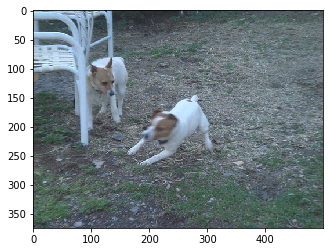

Greedy: white dog is running through the grass


array([[0.18175082, 2.0638275 , 0.12197638, ..., 0.04279743, 0.14760417,
        1.0165954 ]], dtype=float32)

In [228]:
z+=1
pic = test_paths[z][0]
image = encoded_test_vectors[z]
# pic = test_list[z-30]
image=image.reshape(1,2048)
x=plt.imread(pic)
plt.imshow(x)
plt.show()
print("Greedy:",pSearch(image))
image

In [211]:
# encoded_image_input_train[11]

array([0.16182034, 0.14616564, 0.08214632, ..., 0.10798354, 1.438901  ,
       0.44214386], dtype=float32)